In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from tqdm import trange

In [2]:
data_raw = fits.open('muram_snapshot_for_david.fits')
data_raw.info() 

Filename: muram_snapshot_for_david.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       8   (70, 3, 1024, 5)   float64   


In [3]:
T_sim = data_raw[0].data[0, 0:50, 0, :]
# Let's take only 50 pixels in x direction
np.shape(T_sim) 

(50, 70)

In [4]:
N_x = len(T_sim[: , 0])
N_z = len(T_sim[0 , :])

# Physical constants
m_sr = 1.23 * 1.66053906660e-27   # kg
k_b = 1.380649e-23               # J/K
g = 274.0                        # m/s^2
z_max = N_z * 24000              # m
x_max = N_x * 24000              # m

T0 = 6000.0
H0 = k_b * T0 / (m_sr * g)

In [5]:
x_sim = np.linspace(0, x_max, N_x)
z_sim = np.linspace(0, z_max, N_z)

z_scaler = z_max

X, Z = np.meshgrid(x_sim, z_sim, indexing="ij")  # (N_x, N_z)


X_flat = torch.from_numpy(X / x_max).float().reshape(-1, 1)
Z_flat = torch.from_numpy(Z / H0).float().reshape(-1, 1)

X_in = torch.cat([X_flat, Z_flat], dim=1)

T_max = T_sim.max()
T_target = torch.from_numpy(T_sim.astype(np.float32)).reshape(-1, 1)
T_target = T_target / T_max

In [6]:
#Defining NN 
class TempNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 32),
            nn.Tanh(),
            nn.Linear(32, 64),
            nn.Tanh(),
            nn.Linear(64, 128),
            nn.Tanh(),
            nn.Linear(128, 128),
            nn.Tanh(),
            nn.Linear(128, 64),
            nn.Tanh(),
            nn.Linear(64, 32),
            nn.Tanh(),
            nn.Linear(32, 1),
            nn.Sigmoid()   # daje izlaz u opsegu (0,1)
        )

    def forward(self, x):
        return self.net(x)

In [7]:
model = TempNN()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = nn.MSELoss()
loss_history = []
for epoch in trange(50000, desc="Training"):
    optimizer.zero_grad()

    T_pred = model(X_in)
    loss = loss_fn(T_pred, T_target)

    loss.backward()
    optimizer.step()

    loss_history.append(loss.item())

    if epoch % 25000 == 0:
        print(f"Epoch {epoch}, Loss = {loss.item():.4e}")


Training:   0%|          | 26/50000 [00:00<06:43, 123.83it/s]

Epoch 0, Loss = 8.9745e-02


Training:  50%|█████     | 25014/50000 [05:22<05:03, 82.22it/s]

Epoch 25000, Loss = 9.7714e-05


Training: 100%|██████████| 50000/50000 [10:46<00:00, 77.32it/s]


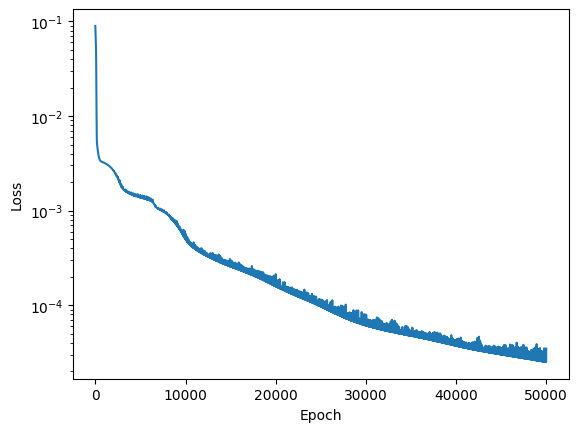

In [8]:
plt.semilogy(loss_history)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

Text(0, 0.5, 'y (m)')

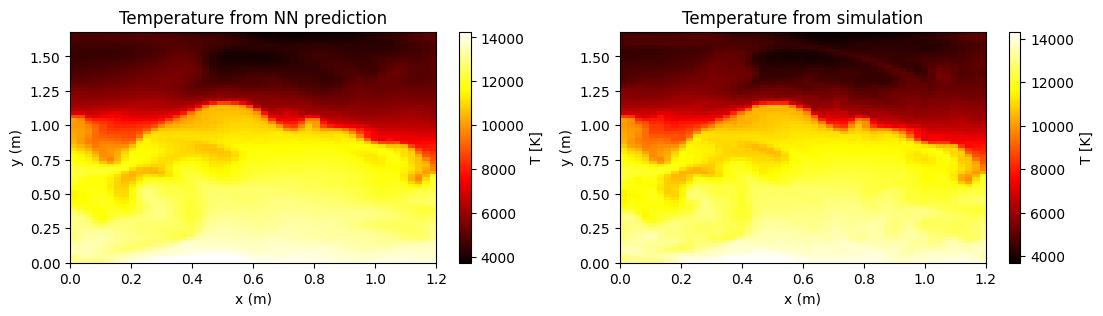

In [14]:
T_recon = T_pred.detach().numpy().reshape(T_sim.shape) * T_max
fig, ax = plt.subplots(1, 2, figsize = (13,3))
ax[0].imshow(T_recon.transpose(1,0), label = "NN prediction")
fig.colorbar(ax[0].imshow(T_recon.transpose(1,0), extent=[0, x_max/1e6, 0, z_max/1e6], aspect='auto', origin='lower', cmap='hot'), label = "T [K]")
ax[0].set_title('Temperature from NN prediction')
ax[0].set_xlabel('x (m)')
ax[0].set_ylabel('y (m)')

ax[1].imshow(T_sim.transpose(1,0))
fig.colorbar(ax[1].imshow(T_sim.transpose(1,0), extent=[0, x_max/1e6, 0, z_max/1e6], aspect='auto', origin='lower', cmap='hot'), label = "T [K]")
ax[1].set_title('Temperature from simulation')
ax[1].set_xlabel('x (m)')
ax[1].set_ylabel('y (m)')